<a href="https://colab.research.google.com/github/HeshanNavindu-7/Pneumonia-Detection/blob/main/pneumonia_detection_CheXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images


100%|██████████| 1.17G/1.17G [00:07<00:00, 175MB/s]

In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/labeled-chest-xray-images/chest_xray"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


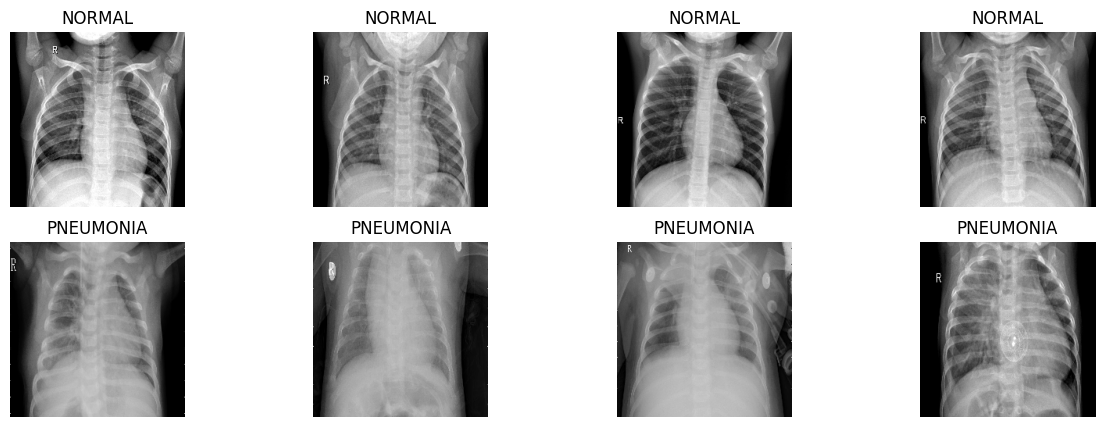

Test Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


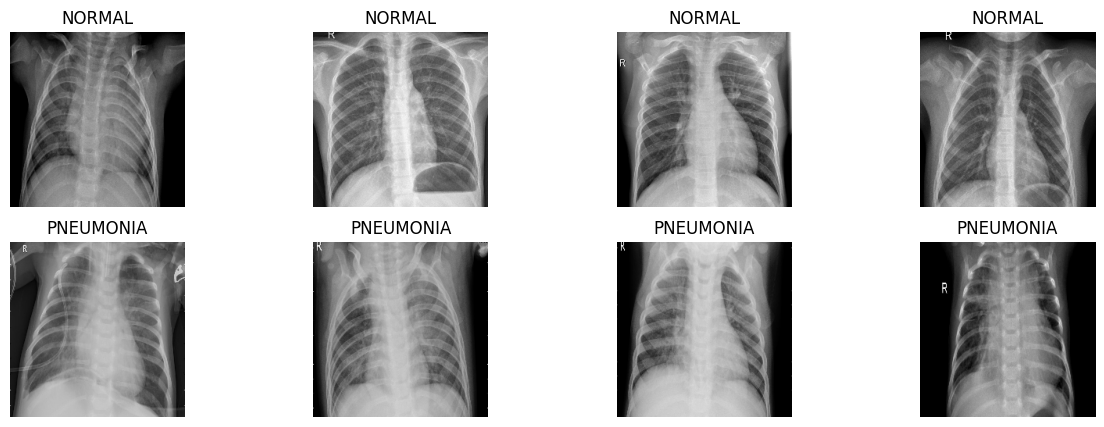

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

# Define image size and batch size
target_size = (224, 224)  # Adjusted to 224x224
batch_size = 32

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import copy

# Define subdirectories for train and test data
root_dir = '/content/labeled-chest-xray-images/chest_xray'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

# Define image size and batch size
target_size = (224, 224)  # Adjusted to 224x224
batch_size = 32

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Custom Dataset Class with Data Augmentation
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ensure only image files are processed
                    self.image_paths.append(os.path.join(class_dir, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define standard transformations for test dataset (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders with augmentation
train_dataset = ChestXRayDataset(train_dir, transform=train_transform)
test_dataset = ChestXRayDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Train Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


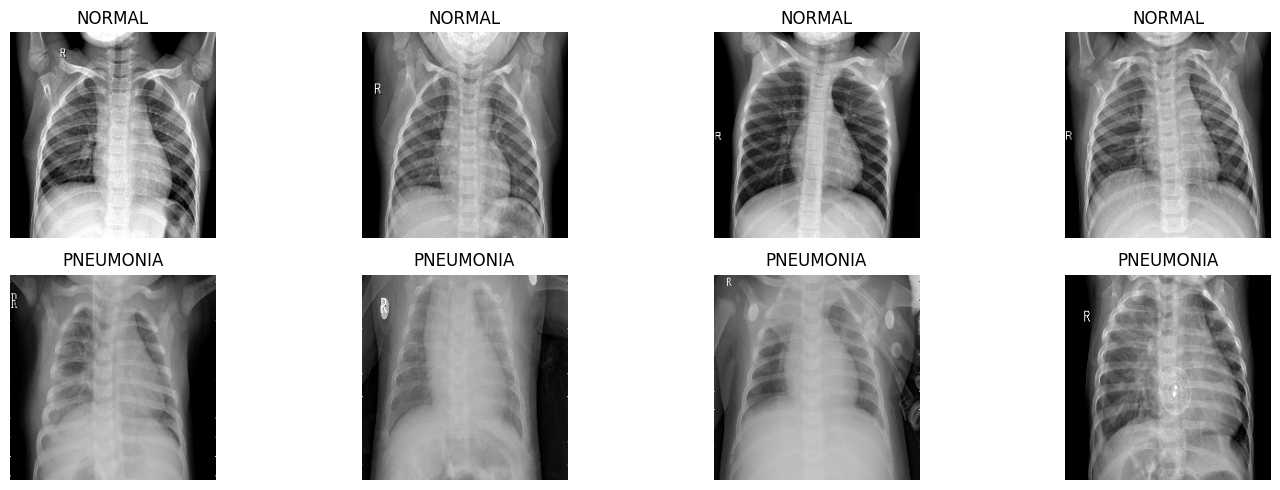

Test Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


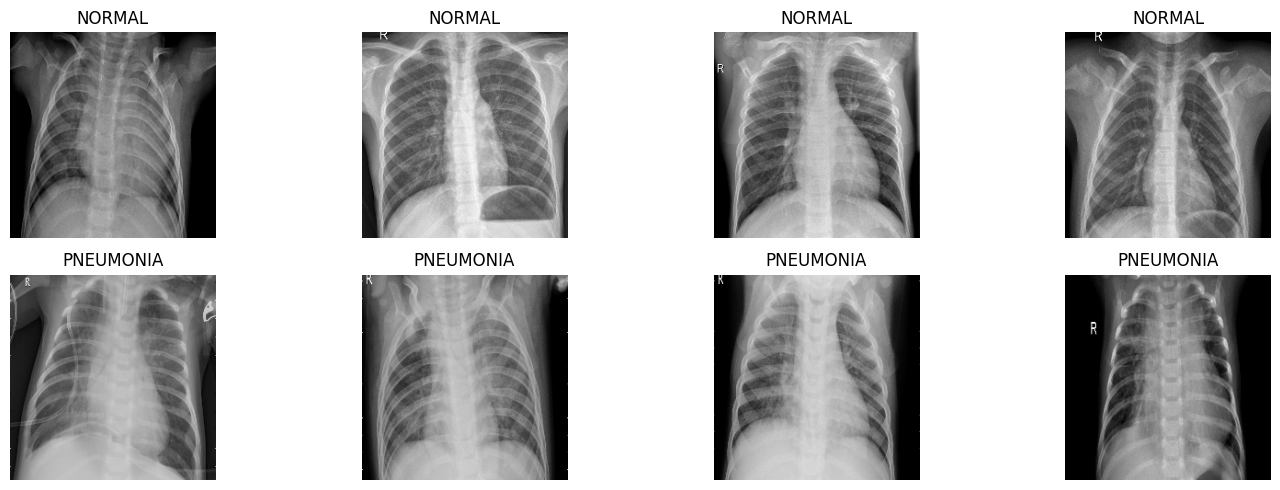

In [7]:
# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.tight_layout()
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)

In [8]:
!pip install torch

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the model (example with CheXNet)
class CheXNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CheXNet, self).__init__()
        self.densenet = models.densenet121(weights=None)  # Set weights to None to avoid download
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x

try:
    # Instantiate the model
    model = CheXNet(num_classes=2)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Print model architecture and number of parameters
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Example of input size (assuming 3 channels RGB and size 224x224)
    input_example = torch.randn(1, 3, 224, 224).to(device)
    output_example = model(input_example)
    print(f"Output shape: {output_example.shape}")

except Exception as e:
    print(f"An error occurred: {e}")


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [10]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy


In [12]:
# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 0.2970, Train Accuracy: 0.8721
Validation Loss: 0.2339, Validation Accuracy: 0.9103
Epoch 2/10
Train Loss: 0.1735, Train Accuracy: 0.9358
Validation Loss: 0.2908, Validation Accuracy: 0.8862
Epoch 3/10
Train Loss: 0.1595, Train Accuracy: 0.9404
Validation Loss: 0.2229, Validation Accuracy: 0.9006
Epoch 4/10
Train Loss: 0.1400, Train Accuracy: 0.9440
Validation Loss: 0.6189, Validation Accuracy: 0.8077
Epoch 5/10
Train Loss: 0.1186, Train Accuracy: 0.9541
Validation Loss: 0.2680, Validation Accuracy: 0.9151
Epoch 6/10
Train Loss: 0.1191, Train Accuracy: 0.9537
Validation Loss: 0.3947, Validation Accuracy: 0.8622
Epoch 7/10
Train Loss: 0.1064, Train Accuracy: 0.9597
Validation Loss: 0.5966, Validation Accuracy: 0.8029
Epoch 8/10
Train Loss: 0.1088, Train Accuracy: 0.9591
Validation Loss: 0.2365, Validation Accuracy: 0.9135
Epoch 9/10
Train Loss: 0.1092, Train Accuracy: 0.9578
Validation Loss: 0.3242, Validation Accuracy: 0.8862
Epoch 10/10
Train Loss: 0.1061, Train

In [14]:
# Evaluate on the test dataset
test_loss, test_accuracy = validate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2813, Test Accuracy: 0.9006


In [15]:
# Evaluate on the test dataset
train_loss, train_accuracy = validate(model, train_loader, criterion, device)

print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Train Loss: 0.0831, Train Accuracy: 0.9690


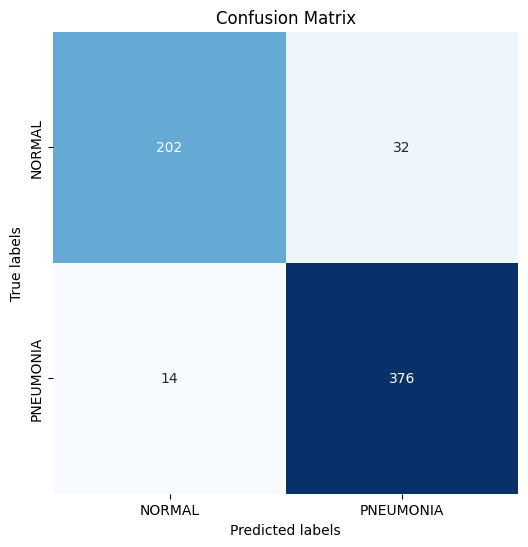

              precision    recall  f1-score   support

      NORMAL       0.94      0.86      0.90       234
   PNEUMONIA       0.92      0.96      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage after training
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=['NORMAL', 'PNEUMONIA'])

# Classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))


<Figure size 600x600 with 0 Axes>

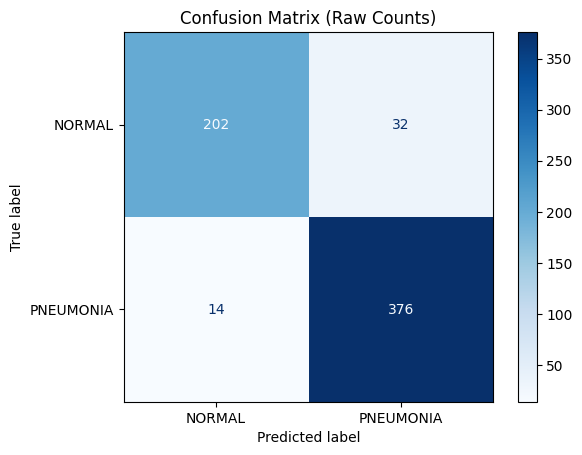

<Figure size 600x600 with 0 Axes>

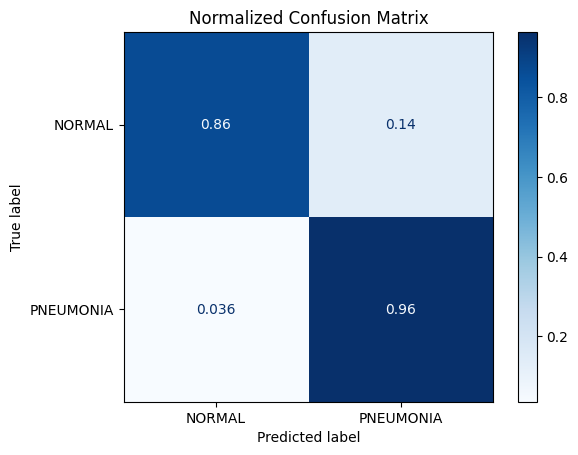

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix (raw counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Raw Counts)')
plt.show()

# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['NORMAL', 'PNEUMONIA'])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define your dataset and DataLoader here

# Define your model class here

# Define your training and validation functions here

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Append to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')
ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, train_accuracies, label='Training Accuracy', color='tab:green')
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import os
# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(val_labels, val_preds, target_names=classes)
print("Classification Report:")
print(class_report)

# F1 Score, Precision, Recall
f1 = f1_score(val_labels, val_preds, average='weighted')
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

NameError: name 'val_labels' is not defined

In [37]:
import h5py

# Save entire model state
torch.save(model.state_dict(), 'CheXNet.h5')

# To load the model later
model = CheXNet(num_classes=2)
model.load_state_dict(torch.load('CheXNet.h5'))
model.eval()


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [38]:
import pickle

# Save entire model state
torch.save(model.state_dict(), 'model.pkl')

# To load the model later
model = CheXNet(num_classes=2)
model.load_state_dict(torch.load('model.pkl'))
model.eval()


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [42]:
import pickle

# Save entire model state
torch.save(model.state_dict(), 'CheXNet.pkl')

# To load the model later
model = CheXNet(num_classes=2)
model.load_state_dict(torch.load('CheXNet.pkl'))
model.eval()


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.